## **[1] Importación de Librerías**

In [ ]:
# Install the 'segmentation-models-pytorch' library using pip
!pip install segmentation-models-pytorch

In [ ]:
# ===============================
# 1️⃣ Core Python Libraries
# ===============================
import os  # For file and directory manipulation
import warnings
import numpy as np  # For numerical operations, especially on arrays
from google.colab import files
from google.colab import drive
import random
import pickle

# ===============================
# 2️⃣ Image Processing (General)
# ===============================
import matplotlib.pyplot as plt  # For plotting images and graphs
import cv2
from skimage.filters.thresholding import threshold_local  # Adaptive/local thresholding
from skimage.filters import threshold_otsu

# ===============================
# 3️⃣ PyTorch Libraries
# ===============================
import torch  # Main PyTorch library for tensor computations
import torch.nn as nn  # Sub-library for neural networks and layers

# ===============================
# [4] Segmentation Models
# ===============================
import segmentation_models_pytorch as smp  # Pretrained segmentation models and utilities (UNet, DeepLabV3+, etc.)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ===============================
# 🔒 Reproducibility Settings
# ===============================
warnings.filterwarnings("ignore")  # Ignore all warning messages
random_seed = 3301

# Set the seed for generating random numbers in PyTorch (CPU)
torch.manual_seed(random_seed)
# Set the seed for generating random numbers in PyTorch (GPU) across all devices
torch.cuda.manual_seed_all(random_seed)
# Set the seed for generating random numbers in NumPy
np.random.seed(random_seed)
# Set the seed for generating random numbers in the Python random module
random.seed(random_seed)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **[2] Carga de Modelo**

In [ ]:
# Choose architecture and encoder for the segmentation model
u_net = smp.Unet(
    encoder_name="resnet34",        # Backbone architecture (ResNet34)
    encoder_weights="imagenet",     # Use pretrained weights from ImageNet
    in_channels=4,                  # Input has 4 channels (R, G, B, NIR)
    classes=1,                      # Output has 1 channel for binary segmentation
    activation=None
).to(device)  # Move model to the specified device

In [ ]:
# `torch.load` loads the checkpoint (which includes model weights, optimizer state, etc.)
checkpoint = torch.load('/content/best_model_allp.pth', map_location=device)

# The checkpoint contains a dictionary with the model's state dict (weights, parameters).
u_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## **[3] Carga de datos para métricas**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/MyDrive/Andreita\'s all for one/tiles.pkl', 'rb') as f:
    tiles = pickle.load(f)

## **[4] Predicciones, binarización y métricas**

### **[1] Prediccion de U-Net**

In [ ]:
def predict(model, img_tensor, device):
    """
    Predict segmentation mask for a single image.

    Args:
        model (nn.Module): Trained segmentation model
        img_tensor (torch.Tensor): Input image tensor of shape (4, H, W)
        device (torch.device): Device to run inference on

    Returns:
        dict: Dictionary containing prediction and metadata
            - 'prediction': Probability map (numpy array, shape H x W, values 0-1)
    """
    model.eval()

    # Run inference
    with torch.no_grad():
        output = model(img_tensor)  # Raw logits
        prediction = torch.sigmoid(output).cpu().numpy()[0, 0]  # Probability map (H, W)

    return prediction

In [ ]:
def apply_mask(img, prediction, pred_threshold=0.4):
    """
    Apply model prediction mask to the original image and filter by NDVI.

    Args:
        img (np.ndarray): Original image with shape (H, W, C) where one channel contains pre-calculated NDVI
        prediction (np.ndarray): Model prediction probability map with shape (H, W), values in [0, 1]
        pred_threshold (float): Threshold to binarize prediction (default: 0.4)

    Returns:
        masked_img (np.ndarray): Original image with mask applied
    """
    # Binarize predictionc
    binary_pred = (prediction > pred_threshold).astype(np.float32)

    # Apply mask to image
    masked_img = img.copy()
    masked_img[binary_pred == 0] = 0

    return masked_img

### **[2] Métodos de binarización**

In [ ]:
def otsu_rgb(rgb):
    """
    Otsu's method on RGB image (grayscale converted).
    This is used as the "ground truth" reference.
    Ignores black background pixels (value 0).

    Args:
        rgb (np.ndarray): RGB image (H, W, 3), values in [0, 1]

    Returns:
        np.ndarray: Binary mask (H, W), values {0, 1}
    """
    # Convert RGB to grayscale
    gray = cv2.cvtColor((rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    # Convert the RGB image to grayscale.
    # The image is first scaled to the [0, 255] range, then cast to uint8 as required by OpenCV for the `cvtColor` function.
    # The resulting grayscale image is stored in the 'gray' variable.

    # Compute the optimal threshold using Otsu's method
    threshold = threshold_otsu(gray)
    # Apply Otsu's method using the `threshold_otsu` function (from scikit-image) to find the optimal threshold
    # that minimizes the intra-class variance between the background and foreground in the grayscale image.
    # The calculated threshold value is stored in the 'threshold' variable.

    mask = (gray < threshold).astype(np.float32)
    # Create a mask where pixel values in the grayscale image are below the computed threshold.
    # This mask will have values of 1 for pixels below the threshold (foreground) and 0 for pixels above the threshold (background).
    # The result is cast to `np.float32` to ensure compatibility with the next operation.

    binary = gray * mask
    # Multiply the grayscale image by the mask. This zeros out the background pixels (those above the threshold) and keeps the foreground pixels (below the threshold).
    # The result is stored in the 'binary' variable.

    binary[binary > 0] = 1
    # Set any non-zero pixel in the 'binary' image to 1. This finalizes the binary mask where foreground is represented as 1 and background as 0.

    return binary  # Return the binary mask (H, W), with values {0, 1}

In [ ]:
def threshold_ndvi(ndvi, threshold=0.0):
    """
    Simple threshold binarization on NDVI channel.

    Args:
        ndvi (np.ndarray): NDVI channel (H, W), values in [-1, 1]
        threshold (float): NDVI threshold (default: 0.0)

    Returns:
        np.ndarray: Binary mask (H, W), values {0, 1}
    """
    # Create a binary mask where NDVI values greater than the threshold are set to 1 (foreground),
    # and those less than or equal to the threshold are set to 0 (background).
    mask = (ndvi > threshold).astype(np.uint8)
    # Convert the result to np.uint8 to ensure the output is in the standard binary format (0 or 1).

    # Set NDVI values of 0 to 0 in the normalized image
    mask[ndvi == 0] = 0
    # Ensure that pixels where the NDVI value is exactly 0 are set to 0 in the mask.

    return mask  # Return the binary mask (H, W), with values {0, 1}

In [ ]:
def otsu_ndvi(ndvi):
    """
    Otsu's method on NDVI channel.

    Args:
        ndvi (np.ndarray): NDVI channel (H, W), values in [-1, 1]

    Returns:
        np.ndarray: Binary mask (H, W), values {0, 1}
    """
    # Normalize NDVI to [0, 255] for Otsu
    ndvi_normalized = ((ndvi + 1) / 2 * 255).astype(np.uint8)
    # NDVI values typically range from -1 to 1.
    # To make it compatible with OpenCV, the NDVI values are first shifted to the [0, 1] range by adding 1,
    # and then scaled to the [0, 255] range for OpenCV thresholding.
    # The resulting array is cast to uint8, as OpenCV requires this data type for thresholding.

    # Compute the optimal threshold using Otsu's method
    threshold = threshold_otsu(ndvi_normalized)
    # Apply Otsu's method to find the optimal threshold for binarization.
    # Otsu's method computes a threshold that best separates foreground (vegetation) from background (non-vegetation)
    # in the NDVI image by minimizing the intra-class variance.

    mask = (ndvi_normalized > threshold).astype(np.float32)
    # Create a binary mask where pixels with NDVI values greater than the threshold are set to 1 (foreground),
    # and those below the threshold are set to 0 (background). This results in a binary mask (0 and 1).
    # Cast the result to np.float32 to ensure compatibility with further image processing steps.

    # Set NDVI values of 0 to 0 in the normalized image
    mask[ndvi == 0] = 0
    # Ensure that pixels where the NDVI value is exactly 0 are set to 0 in the mask.
    # This avoids the issue where Otsu’s thresholding might incorrectly classify these areas due to the lack of strong contrast.

    return mask  # Return the binary mask (H, W), with values {0, 1}

In [ ]:
def local_ndvi(ndvi, block_size=1024):
    """
    Adaptive local thresholding on NDVI channel.

    Args:
        ndvi (np.ndarray): NDVI channel (H, W), values in [-1, 1]
        block_size (int): Size of pixel neighborhood (must be odd, default: 35)

    Returns:
        np.ndarray: Binary mask (H, W), values {0, 1}
    """
    # Normalize NDVI to [0, 255]
    ndvi_normalized = ((ndvi + 1) / 2 * 255).astype(np.uint8)
    # NDVI values typically range from -1 to 1.
    # To make it compatible with image processing techniques, NDVI values are first shifted to the range [0, 1]
    # by adding 1, then scaled to the range [0, 255] for processing.
    # The resulting array is cast to uint8 to comply with thresholding methods in libraries like scikit-image.

    # Ensure block_size is odd
    if block_size % 2 == 0:
        block_size += 1
    # Block size for local thresholding must be odd to have a defined center pixel.
    # If the input block_size is even, increment it by 1 to make it odd.

    # Compute local adaptive threshold
    local_thresh = threshold_local(ndvi_normalized, block_size=block_size, method='gaussian', offset=2)
    # Use the `threshold_local` function from scikit-image to compute an adaptive threshold for each pixel
    # based on its local neighborhood. The `block_size` defines the size of the local region, and `method='gaussian'`
    # applies a Gaussian-weighted mean for the thresholding. The `offset=2` ensures that the threshold is adjusted
    # to prevent overly sensitive thresholding.

    # Apply threshold: high NDVI > local threshold
    mask = (ndvi_normalized > local_thresh).astype(np.uint8)
    # Generate a binary mask by comparing the normalized NDVI values to the local adaptive threshold.
    # Pixels with NDVI values greater than the local threshold are classified as foreground (1), and the rest as background (0).
    # The result is cast to `np.uint8` to ensure it's in the binary format.

    # Set NDVI values of 0 to 0 in the normalized image
    mask[ndvi == 0] = 0
    # Ensure that pixels where the NDVI value is exactly 0 are set to 0 in the mask.

    return mask  # Return the binary mask (H, W), with values {0, 1}

### **[3] Métricas de binarización**

In [ ]:
def binarization_metrics(predicted, ground_truth):
    """
    Compute evaluation metrics for binary classification or segmentation tasks.

    Parameters:
    - predicted (np.ndarray): Binary prediction array (e.g., output of a model after thresholding).
    - ground_truth (np.ndarray): Binary ground truth array (true labels/masks).

    Returns:
    - dict: A dictionary containing accuracy, precision, recall, F1 score, IoU, and Dice coefficient.
    """

    # Flatten arrays to 1D for compatibility with sklearn metrics
    pred_flat = predicted.flatten()
    gt_flat = ground_truth.flatten()

    # Accuracy: (TP + TN) / (TP + TN + FP + FN)
    accuracy = accuracy_score(gt_flat, pred_flat)

    # Precision: TP / (TP + FP)
    # zero_division=0 avoids division by zero if there are no predicted positives
    precision = precision_score(gt_flat, pred_flat, zero_division=0)

    # Recall (Sensitivity): TP / (TP + FN)
    recall = recall_score(gt_flat, pred_flat, zero_division=0)

    # F1 Score: Harmonic mean of precision and recall
    f1 = f1_score(gt_flat, pred_flat, zero_division=0)

    # Return all metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [ ]:
def evaluate_methods(img_np, model, device, gt_name='ndvi_threshold'):
    """
    Apply multiple binarization methods to a 4-channel image and evaluate
    them against a selected ground truth method.

    Args:
        img_np (np.ndarray): Input image array of shape (H, W, 4), where:
                             - Channels 0-2 represent RGB
                             - Channel 3 represents NDVI
        gt_name (str): The key name of the method in 'masks' to be used as the ground truth.
                       Default is 'ndvi_threshold'.

    Returns:
        tuple:
            - results (dict): A dictionary mapping each method name to its evaluation metrics
                              (compared against the selected ground truth).
            - masks (dict): A dictionary mapping each method name to its binary mask.
    """
    # Get model prediction
    img_tensor = torch.from_numpy(img_np.transpose(2, 0, 1)).unsqueeze(0).float().to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        model_prediction = torch.sigmoid(output).cpu().numpy()[0, 0]
        masked_img = apply_mask(img_np, model_prediction)

    # --- Extract RGB and NDVI channels from input image ---
    rgb = masked_img[:, :, :3]      # Extract first three channels as RGB
    ndvi = masked_img[:, :, 3]      # Extract fourth channel as NDVI

    # --- Apply binarization methods to generate binary masks ---
    masks = {
        'rgb_otsu': otsu_rgb(rgb),             # Otsu thresholding on RGB image
        'ndvi_threshold': threshold_ndvi(ndvi),# Fixed thresholding on NDVI
        'ndvi_otsu': otsu_ndvi(ndvi),          # Otsu thresholding on NDVI
        'ndvi_local': local_ndvi(ndvi),        # Local thresholding on NDVI
    }

    # --- Select ground truth mask based on specified method ---
    ground_truth = masks[gt_name]

    # --- Compute evaluation metrics for each method against the ground truth ---
    results = {}
    for method_name, mask in masks.items():
        if method_name != gt_name:
            results[method_name] = binarization_metrics(mask, ground_truth)

    return results, masks, model_prediction, masked_img

In [ ]:
def plot(img_np, results, masks, prediction, masked_img, sample_idx):
    """
    Visualize all binarization methods, model prediction, and their metrics.

    Args:
        img_np (np.ndarray): Original 4-channel image
        masks (dict): Dictionary of binary masks
        prediction (np.ndarray): Model prediction probability map
        results (dict): Dictionary of metrics
        sample_idx (int): Sample index for title
    """
    # Create figure with clean layout - 2 rows, 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Extract data
    rgb = img_np[:, :, :3]
    ndvi = img_np[:, :, 3]

    # ============================================================
    # Plot 1: Original RGB
    # ============================================================
    axes[0].imshow(rgb)
    axes[0].set_title('Original RGB Image', fontsize=13, fontweight='bold', pad=10)
    axes[0].axis('off')

    # ============================================================
    # Plot 2: NDVI Channel
    # ============================================================
    im_ndvi = axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1].set_title('NDVI Channel', fontsize=13, fontweight='bold', pad=10)
    axes[1].axis('off')
    plt.colorbar(im_ndvi, ax=axes[1], fraction=0.046, pad=0.04)

    # ============================================================
    # Plot 3: Model Prediction
    # ============================================================
    axes[2].imshow(prediction, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title('Model Prediction', fontsize=13, fontweight='bold', pad=10)
    axes[2].axis('off')

    # ============================================================
    # Plot 4: Masked RGB Output (Model Applied)
    # ============================================================
    axes[3].imshow(masked_img[:,:,:3])
    axes[3].set_title('Model Result Applied\n(Masked RGB)', fontsize=12, fontweight='bold', pad=10)
    axes[3].axis('off')

    # ============================================================
    # Plot 5: Simple Threshold NDVI (REFERENCE)
    # ============================================================
    axes[4].imshow(masks['ndvi_threshold'], cmap='gray', vmin=0, vmax=1)
    axes[4].set_title('Simple Threshold (NDVI)\n[Reference Method]',
                     fontsize=12, fontweight='bold', pad=10, color='darkgreen')
    axes[4].axis('off')

    # ============================================================
    # Plot 6: Otsu RGB
    # ============================================================
    axes[5].imshow(masks['rgb_otsu'], cmap='gray', vmin=0, vmax=1)
    title = (f"Otsu (RGB)\n"
            f"Acc: {results['rgb_otsu']['accuracy']:.3f} | Pre: {results['rgb_otsu']['precision']:.3f} | "
            f"Rec: {results['rgb_otsu']['recall']:.3f}\n"
            f"F1: {results['rgb_otsu']['f1_score']:.3f}")
    axes[5].set_title(title, fontsize=11, fontweight='bold', pad=10)
    axes[5].axis('off')

    # ============================================================
    # Plot 7: Otsu NDVI
    # ============================================================
    axes[6].imshow(masks['ndvi_otsu'], cmap='gray', vmin=0, vmax=1)
    title = (f"Otsu (NDVI)\n"
            f"Acc: {results['ndvi_otsu']['accuracy']:.3f} | Pre: {results['ndvi_otsu']['precision']:.3f} | "
            f"Rec: {results['ndvi_otsu']['recall']:.3f}\n"
            f"F1: {results['ndvi_otsu']['f1_score']:.3f}")
    axes[6].set_title(title, fontsize=11, fontweight='bold', pad=10)
    axes[6].axis('off')

    # ============================================================
    # Plot 8: Local Adaptive NDVI
    # ============================================================
    axes[7].imshow(masks['ndvi_local'], cmap='gray', vmin=0, vmax=1)
    title = (f"Local Adaptive (NDVI)\n"
            f"Acc: {results['ndvi_local']['accuracy']:.3f} | Pre: {results['ndvi_local']['precision']:.3f} | "
            f"Rec: {results['ndvi_local']['recall']:.3f}\n"
            f"F1: {results['ndvi_local']['f1_score']:.3f}")
    axes[7].set_title(title, fontsize=11, fontweight='bold', pad=10)
    axes[7].axis('off')

    plt.show()

In [ ]:
def evaluate_tiles(tiles, model, device, every = 5):
    """
    Evaluate multiple binarization methods across a list of image tiles.

    Args:
        tiles (list): A list of 4-channel image tiles (each of shape H x W x 4).
                      Each tile should contain [R, G, B, NDVI] channels.
        every (int): Interval at which to visualize intermediate results.
                               Default is every 5 samples.

    Returns:
        dict: A dictionary containing aggregated metrics (mean and std) for each method.
    """

    # Initialize result storage for each method
    aggregated_results = {
        'rgb_otsu': [],
        'ndvi_threshold': [],
        'ndvi_otsu': [],
        'ndvi_local': []
    }

    morph = []

    print(f"Evaluating {len(tiles)} tiles...")
    print("="*80)

    # Process each tile in the dataset
    for i, tile in enumerate(tiles):
        # Apply all binarization methods and evaluate against ground truth
        results, masks, prediction, masked_img = evaluate_methods(tile, model, device)  # Should return method metrics and masks

        # Store the metrics for aggregation later
        for method_name, metrics in results.items():
            aggregated_results[method_name].append(metrics)

        # Visualize results every N tiles (or the first tile)
        if i > 16:
            print(f"\nVisualizing Sample {i + 1}/{len(tiles)}...")
            morph.append(masks['ndvi_threshold'])
            plot(tile, results, masks, prediction, masked_img, i)

        # Print progress every 10 tiles ---
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(tiles)} tiles...")

    # Compute final aggregated metrics (mean & std) for each method
    final_results = {}
    for method_name, metrics_list in aggregated_results.items():
        if not metrics_list:
            continue  # Skip methods with no results

        final_results[method_name] = {
            'accuracy_mean': np.mean([m['accuracy'] for m in metrics_list]),
            'accuracy_std': np.std([m['accuracy'] for m in metrics_list]),
            'precision_mean': np.mean([m['precision'] for m in metrics_list]),
            'precision_std': np.std([m['precision'] for m in metrics_list]),
            'recall_mean': np.mean([m['recall'] for m in metrics_list]),
            'recall_std': np.std([m['recall'] for m in metrics_list]),
            'f1_mean': np.mean([m['f1_score'] for m in metrics_list]),
            'f1_std': np.std([m['f1_score'] for m in metrics_list])
        }

    return morph, final_results

Evaluating 21 tiles...
Processed 10/21 tiles...

Visualizing Sample 18/21...


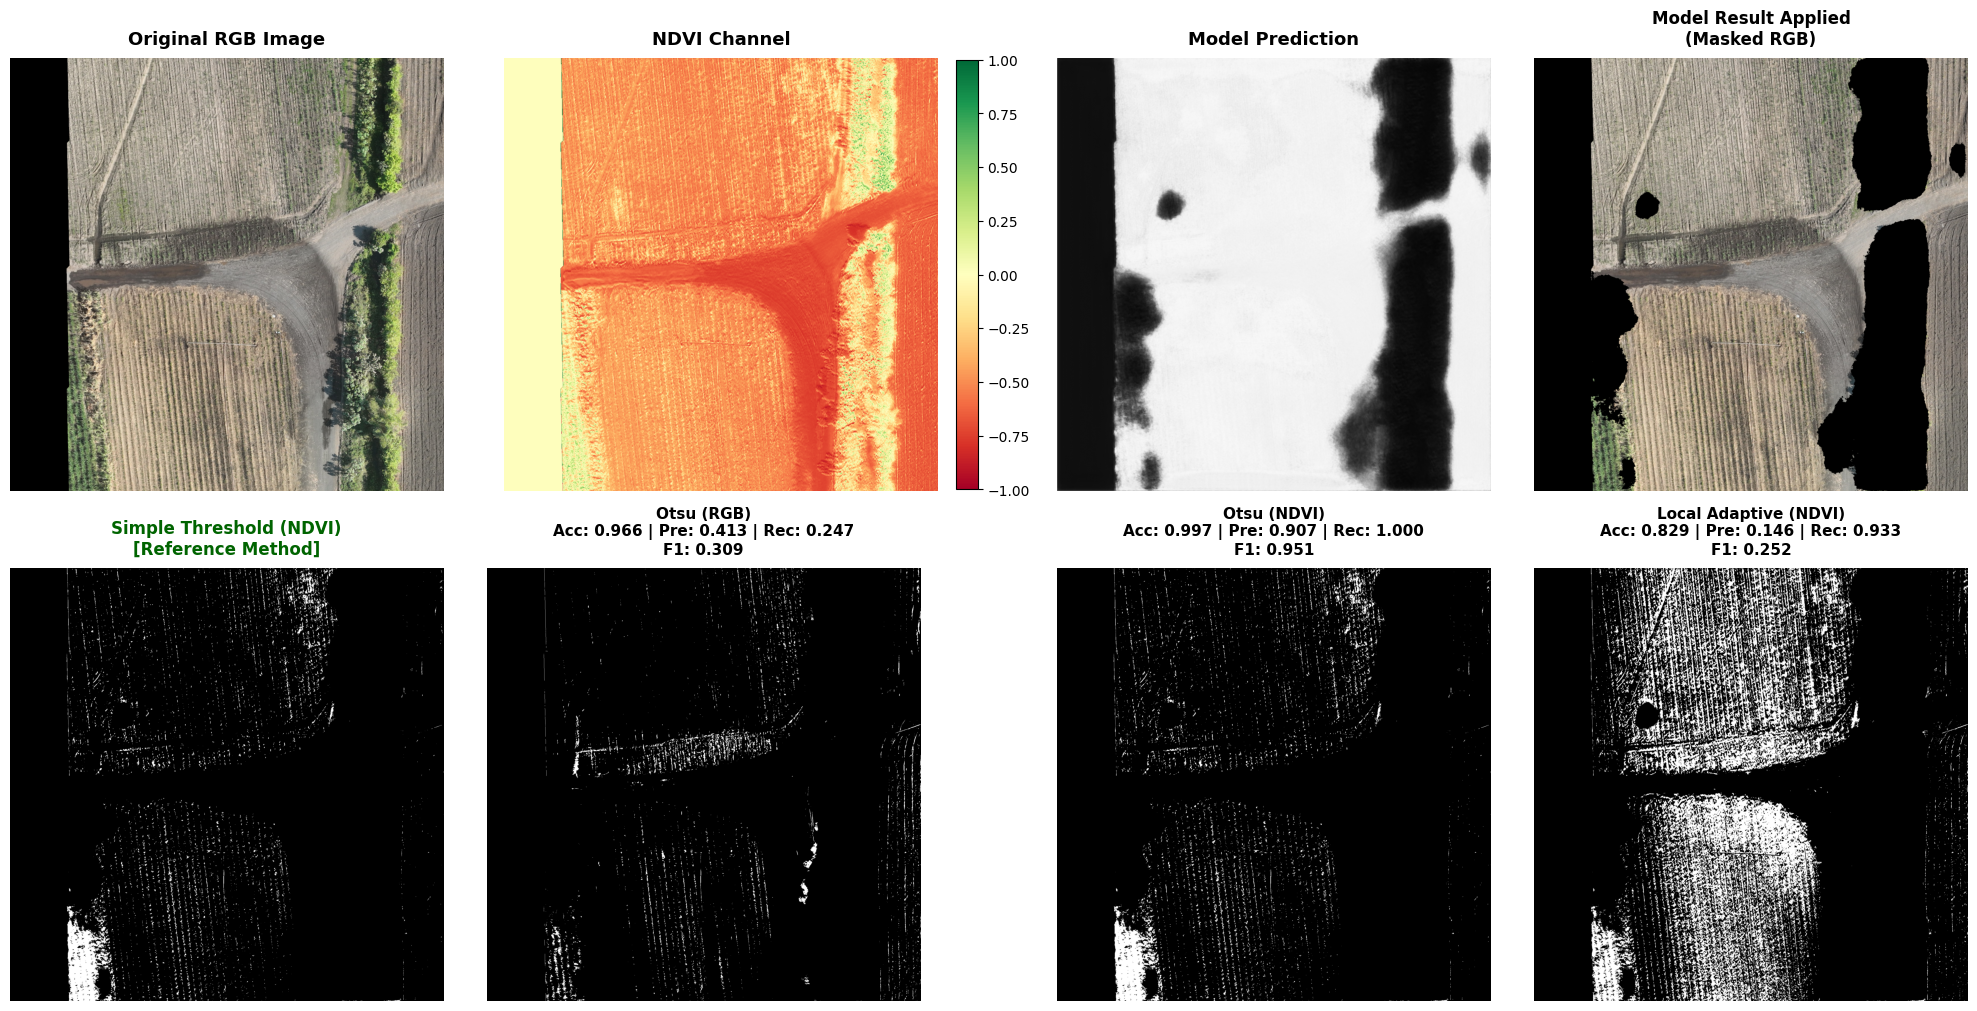


Visualizing Sample 19/21...


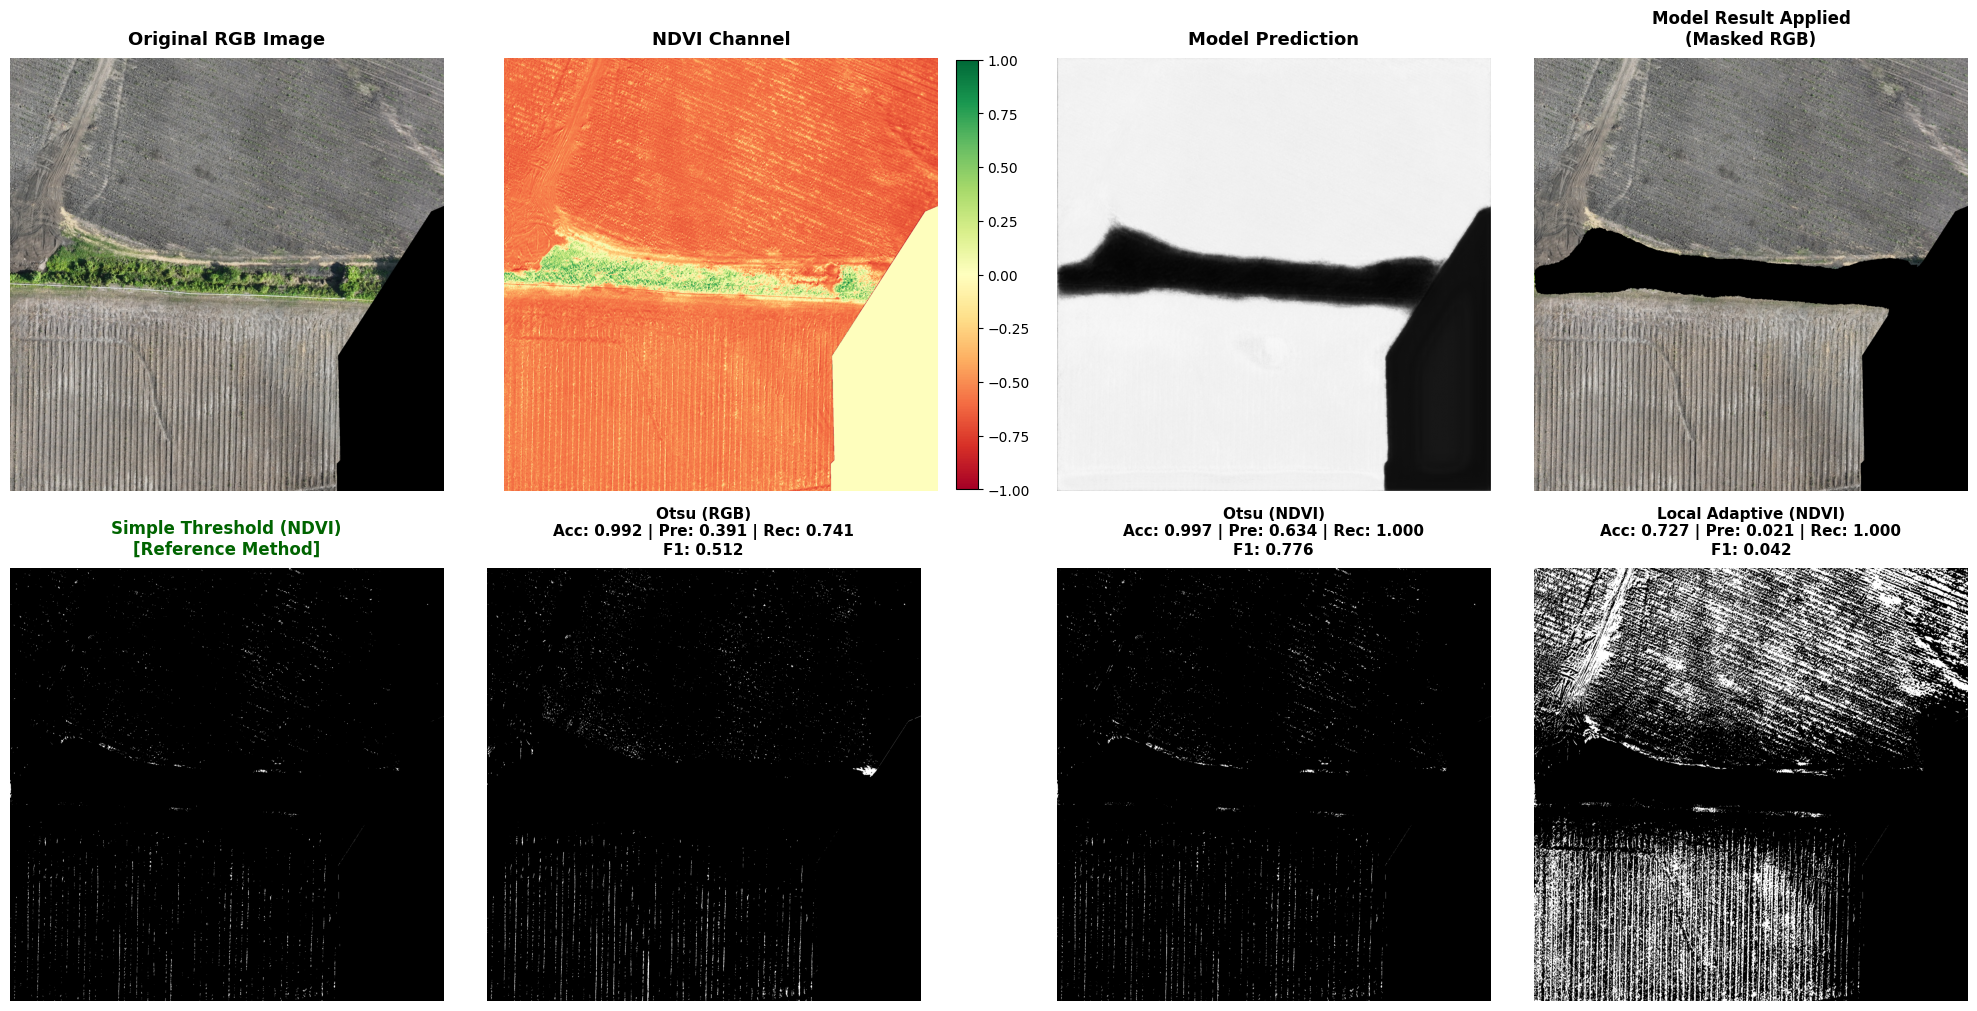


Visualizing Sample 20/21...


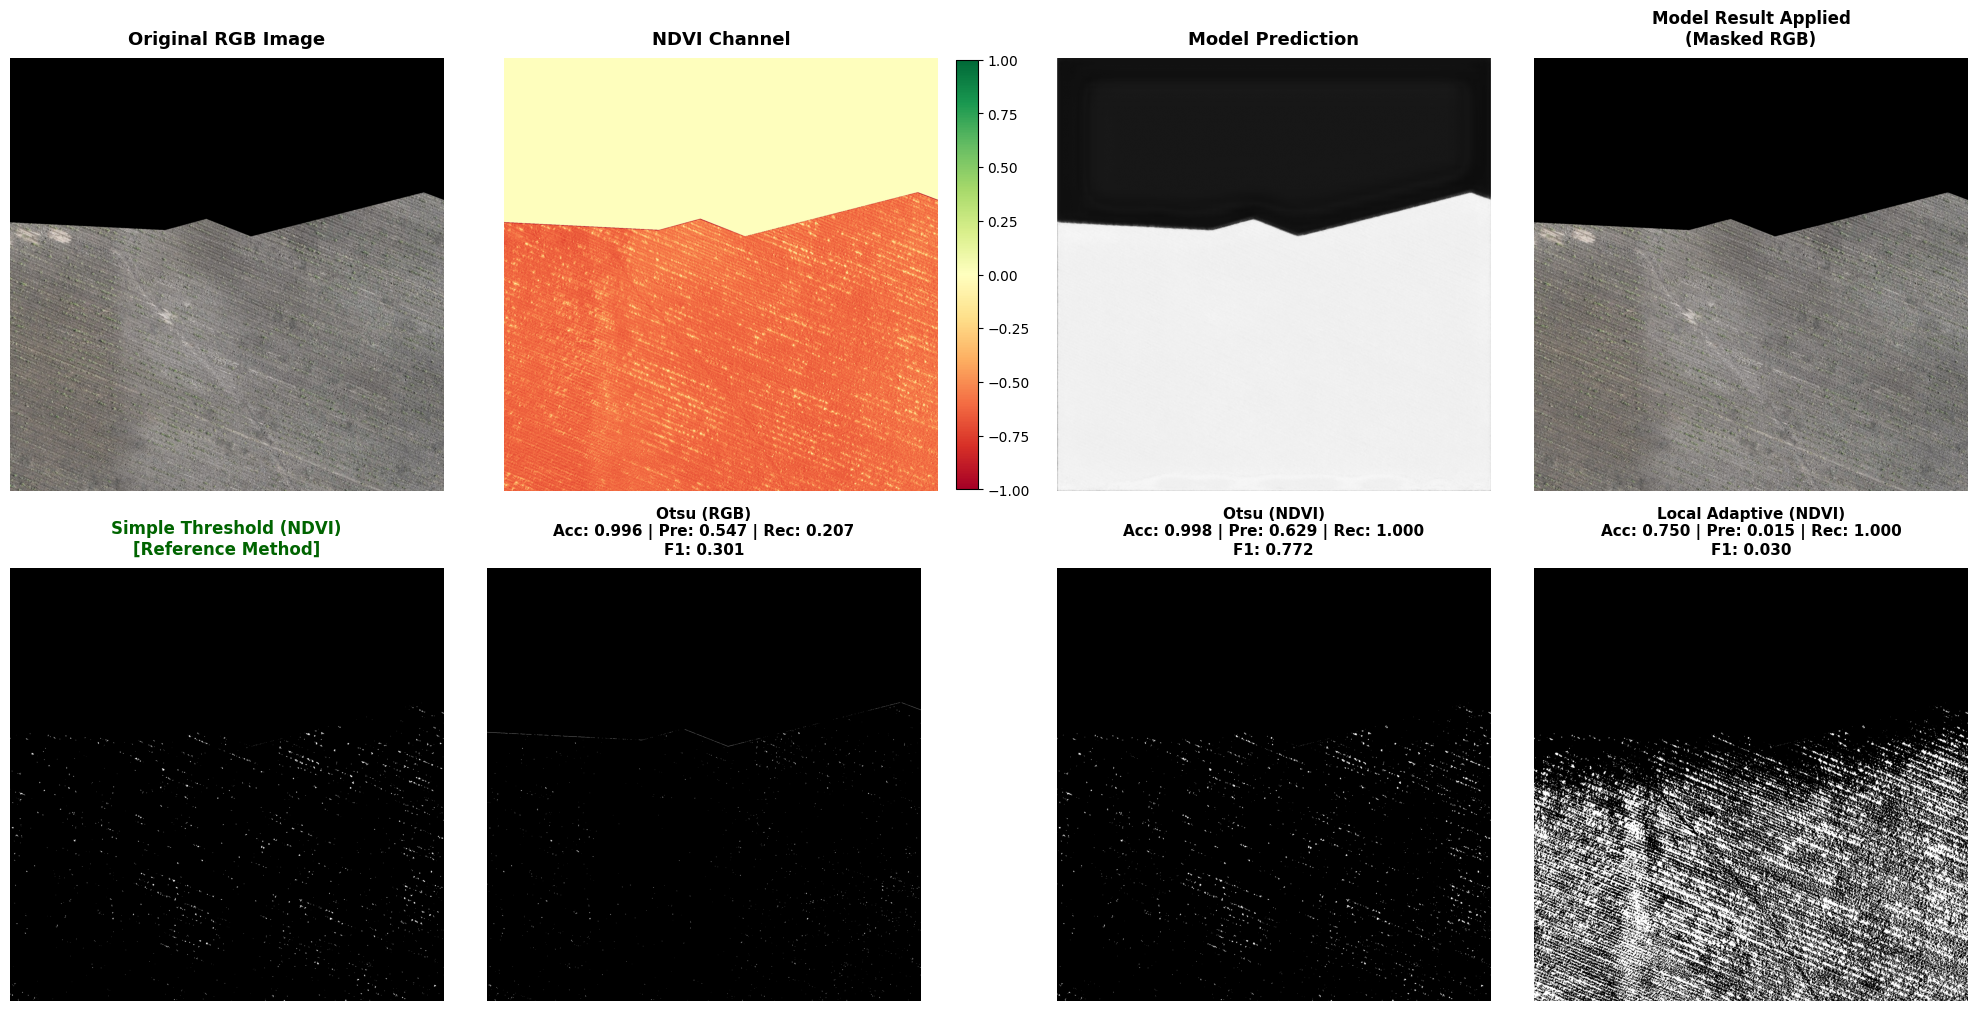

Processed 20/21 tiles...

Visualizing Sample 21/21...


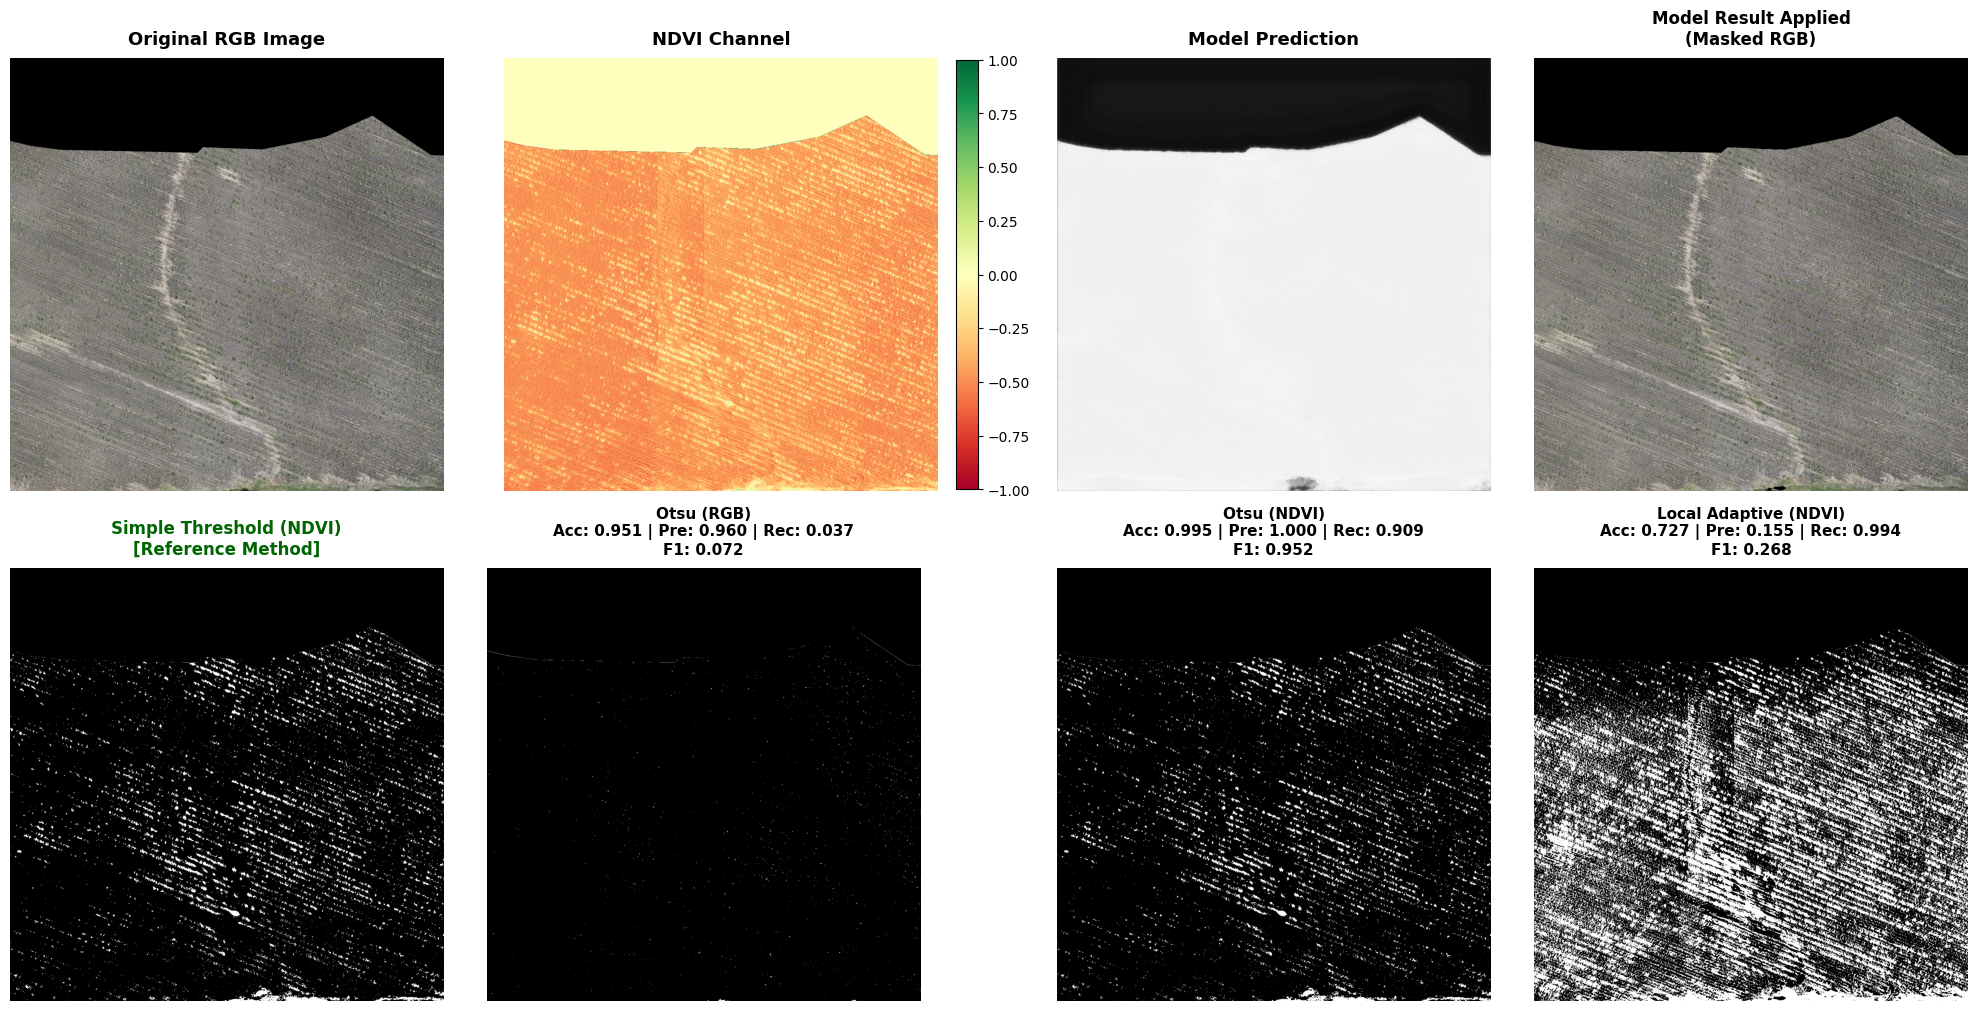

In [ ]:
final_results = evaluate_tiles(tiles, u_net, device)

In [ ]:
morph, metrics = final_results

In [ ]:
print("\n" + "="*80)
print("Binarization Methods Evaluation")
print("Reference: Simple Threshold (NDVI)")
print("="*80)

# Dictionary mapping internal method keys to readable method names
method_names = {
    'ndvi_threshold': 'Simple Threshold [REF]',
    'rgb_otsu': 'Otsu (RGB)',
    'ndvi_otsu': 'Otsu (NDVI)',
    'ndvi_local': 'Local Adaptive'
}

# Print the table header for metric comparison
print(f"\n{'Method':<25} {'Acc':>12} {'Prec':>12} {'Recall':>12} {'F1':>12}")
print("-"*80)

# Define the order in which methods should appear in the output
method_order = ['rgb_otsu', 'ndvi_otsu', 'ndvi_local']

# Loop through each method, retrieve metrics, and print results
# Each metric shows mean ± standard deviation.
for method_key in method_order:

    # Extract the metric dictionary for this method
    m = metrics[method_key]

    # Get the display name (fallback to key if not found)
    name = method_names.get(method_key, method_key)

    # Print formatted metrics with three decimal precision
    print(f"{name:<25} "
          f"{m['accuracy_mean']:.3f}±{m['accuracy_std']:.3f}  "
          f"{m['precision_mean']:.3f}±{m['precision_std']:.3f}  "
          f"{m['recall_mean']:.3f}±{m['recall_std']:.3f}  "
          f"{m['f1_mean']:.3f}±{m['f1_std']:.3f}")

# Print footer line for clean visual separation
print("="*80 + "\n")


Binarization Methods Evaluation
Reference: Simple Threshold (NDVI)

Method                             Acc         Prec       Recall           F1
--------------------------------------------------------------------------------
Otsu (RGB)                0.791±0.195  0.653±0.304  0.415±0.292  0.356±0.168
Otsu (NDVI)               0.904±0.130  0.853±0.264  0.771±0.238  0.738±0.213
Local Adaptive            0.716±0.087  0.366±0.340  0.833±0.168  0.388±0.233



### **[4] Morfología**

In [ ]:
def morphological_preprocess(binarized_img: np.ndarray) -> np.ndarray:
    """
    Preprocess a binarized image by applying a sequence of morphological operations.

    Steps:
    1. Apply first morphological closing.
    2. Apply dilation.

    Args:
        binarized_img (np.ndarray): Input binarized (binary) image.

    Returns:
        np.ndarray: Processed image.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

    # Apply first morphological closing
    processed_img = cv2.morphologyEx(binarized_img, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Apply dilatation
    processed_img = cv2.dilate(processed_img, kernel, iterations=1)

    return processed_img

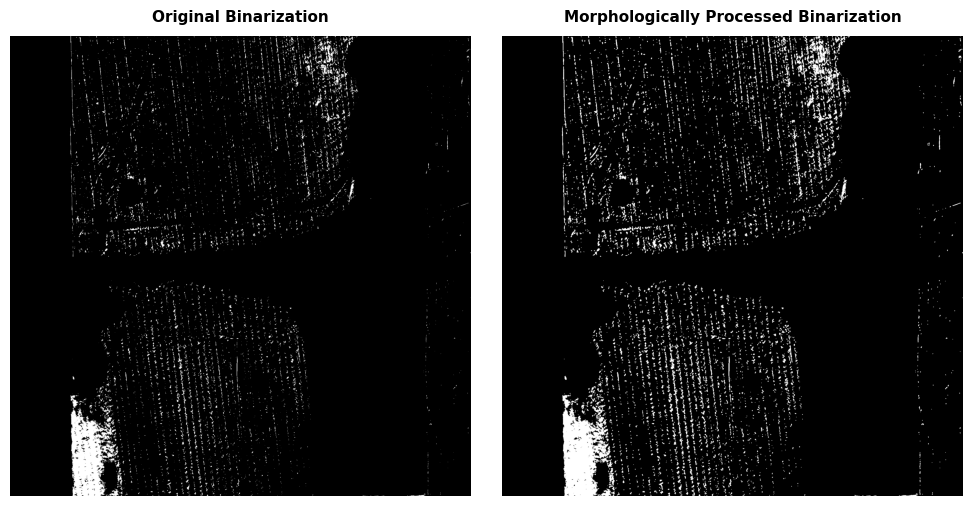

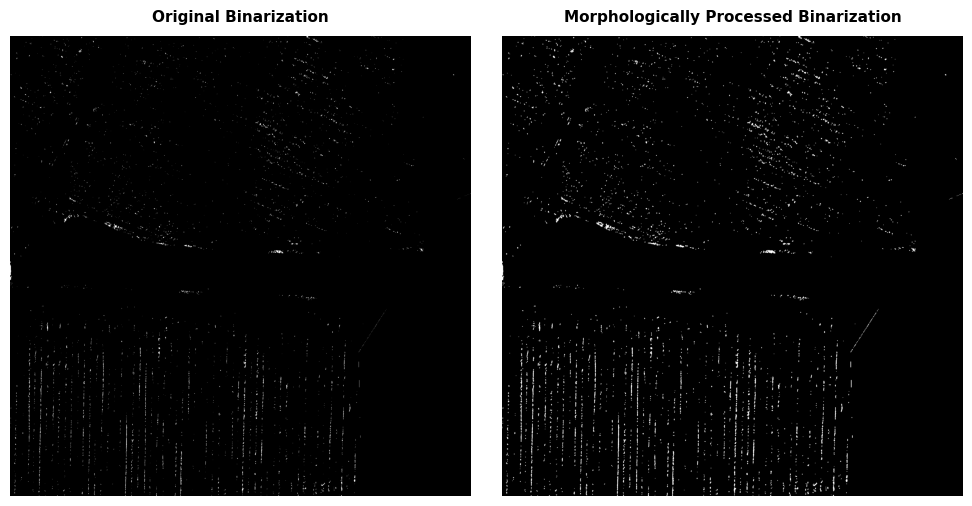

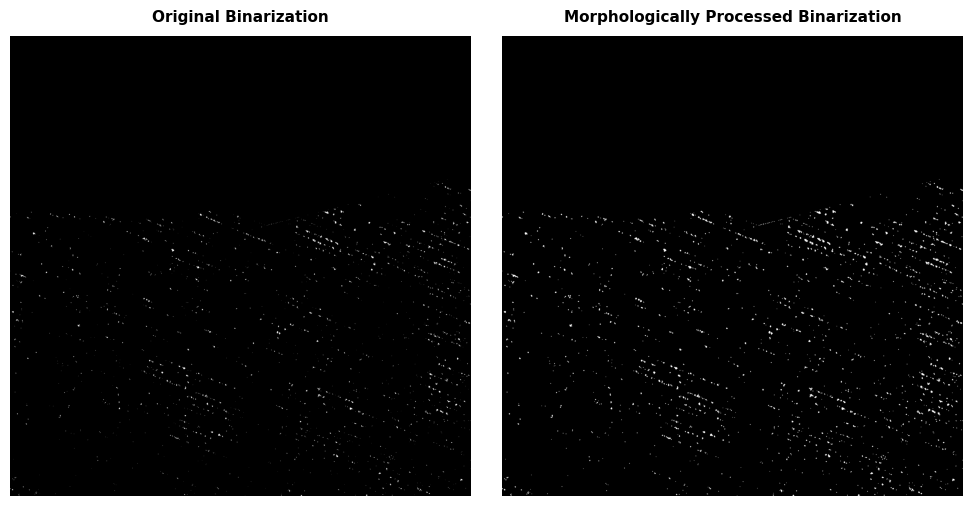

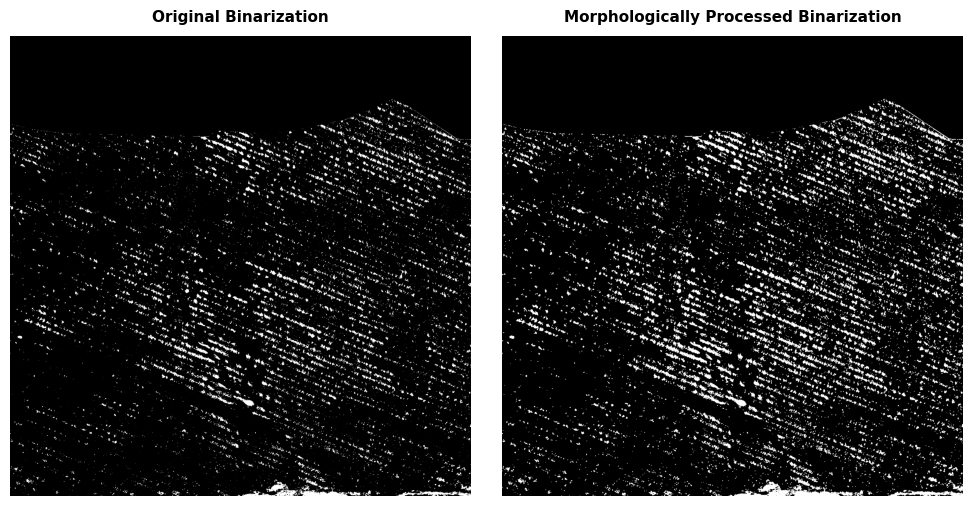

In [ ]:
for i in range(len(morph)):
    # Apply the morphological preprocessing function to the i-th mask
    morph_result = morphological_preprocess(morph[i])

    # Create a figure with 1 row and 2 columns for side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original binarization result
    axes[0].imshow(morph[i], cmap='gray')  # Show original binarization result in grayscale
    axes[0].set_title(f'Original Binarization', fontsize=11, fontweight='bold', pad=10)
    axes[0].axis('off')  # Hide axis ticks for a cleaner display

    # Display the morphologically processed binarization result
    axes[1].imshow(morph_result, cmap='gray')  # Show processed binarization result in grayscale
    axes[1].set_title(f'Morphologically Processed Binarization', fontsize=11, fontweight='bold', pad=10)
    axes[1].axis('off')  # Hide axis ticks for a cleaner display

    # Adjust spacing between subplots for neat layout
    plt.tight_layout()

    # Display the figure
    plt.show()